## Model Fit and Predict - Random Forest Models on Diff Data
Take the best model parameters from the Grid Search done in <code>Model_Eval_RF-Remix</code>, use to fit and predict.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [19]:
#Import Data - USA's differential data
df = pd.read_csv('../data/output/new_features_diffdata.csv')

#Import validation data
#valdf = pd.read_csv('../data/output/new_features_diffdata_validate.csv')
#valdf.head()

## Randomize Data

In [20]:
#Shuffle dataframes before running model to prevent overfitting
from sklearn.utils import shuffle
df = shuffle(df)
#shuffle validation set
#valdf = shuffle(valdf)

In [21]:
#Diagnostic
#df.info()
#list(df.columns)
#df.head()

### Pre-processing data

In [22]:
#Create a list of features to drop that are unneccessary or will bias the prediction
droplist = ['Opp', 'Score_Diff', 'Tries_Diff','Tournament', 'Conv_Diff','-175 : -150', '-149 : -125','-124 : -100', '-99 : -75', '-74 : -25','-24 : -1','0 : 25','26 : 50','51 : 75','76 : 100','101 : 125','126 : 150']

rf_data = df.drop((droplist), axis=1)

#Drop rows with Result == "2" (Ties). This label messes up classification models
rf_data.drop(rf_data[rf_data.Result == 2].index, inplace=True)

In [23]:
#Pull out the variable we're trying to predict: 'Result'
X = rf_data.drop('Result',axis=1)
y = rf_data['Result']
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30)

### Train/Test Split

In [24]:
#Split into train/test/validate sets
#OR, keep as is and use new data for validate
#156 rows in original dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

### Scale data

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [27]:
X_train.head()

,Poss_Time_Diff,Passes_Diff,Contestable_KO_Win_pct_Diff,PenFK_Against_Diff,RuckMaul_Diff,Ruck_Win_pct_Diff,Cards_diff,Lineout_Win_Pct_Diff,Scrum_Win_Pct_Diff
74,2.336449,1.960784,75.0,0.000000,0.0,0.000000,0.0,-1.00,0.5
88,-20.519481,0.000000,0.0,33.333333,20.0,0.000000,0.0,0.00,0.0
111,-18.584071,-24.675325,50.0,-20.000000,0.0,-0.083333,50.0,-1.00,-1.0
145,48.169014,71.428571,-50.0,0.000000,0.0,-0.083333,100.0,0.75,0.0
98,35.576923,56.962025,-100.0,-33.333333,-100.0,0.208333,0.0,0.00,0.0


In [43]:
# transform X_train and X_test
Xtrain_scaled = scaler.transform(X_train)
Xtest_scaled = scaler.transform(X_test)

In [44]:
#Xtrain_scaled[:1]

## Create and fit a Random Forest Classifier Model
Use the parameters found in Grid Search done in <code>Model_Eval_RF-Remix</code> to create and fit model

In [45]:
from sklearn.ensemble import RandomForestClassifier
#Set Random Forest Parameters
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
# fit the pipeline model
rfc.fit(Xtrain_scaled, y_train)

#Predict Classifier
rfc_pred = rfc.predict(Xtest_scaled)

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Random Forest Model Eval

In [47]:
#Accuracy scores
from sklearn.metrics import accuracy_score

rfc_acc = accuracy_score(y_test, rfc_pred)
print(rfc_acc)

0.6304347826086957


In [48]:
#Find Feature Importances
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print("Feature Importance")
print(feature_importances)

Feature Importance
                             importance
Poss_Time_Diff                 0.248541
Passes_Diff                    0.161080
Ruck_Win_pct_Diff              0.127010
PenFK_Against_Diff             0.121239
Contestable_KO_Win_pct_Diff    0.102114
RuckMaul_Diff                  0.091140
Scrum_Win_Pct_Diff             0.077583
Lineout_Win_Pct_Diff           0.050379
Cards_diff                     0.020913


In [65]:
type(feature_importances)
feature_importances.iloc[0]
feature_importances.index
feature_importances.columns

Index(['importance'], dtype='object')

[0.24854062 0.16107986 0.10211383 0.12123923 0.09114045 0.12701049
 0.02091281 0.05037934 0.07758337]


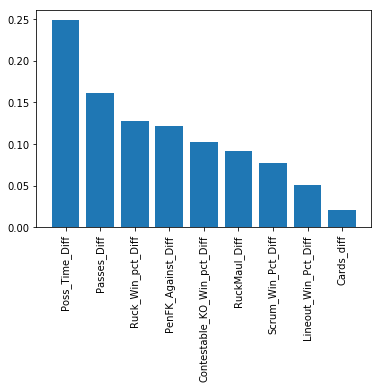

In [72]:
# Plot feature importance
print(rfc.feature_importances_)
# plot
#plt.bar(range(len(rfc.feature_importances_)), rfc.feature_importances_)
plt.xticks(rotation='vertical')
plt.bar(feature_importances.index, feature_importances.importance)
plt.show()

In [53]:
from sklearn.metrics import classification_report,confusion_matrix

#Output confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,rfc_pred))

#import libraries to ignore UndefinedMetricWarning
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

#get the model's accuracy score
accuracy_score(y_test, rfc_pred)
print("\n")
print("Classification Report")
print(classification_report(y_test,rfc_pred))

Confusion Matrix
[[14 11]
 [ 6 15]]


Classification Report
              precision    recall  f1-score   support

           0       0.70      0.56      0.62        25
           1       0.58      0.71      0.64        21

   micro avg       0.63      0.63      0.63        46
   macro avg       0.64      0.64      0.63        46
weighted avg       0.64      0.63      0.63        46



### Save the model in a Pickle

In [52]:
import pickle
# save the model to disk
filename = 'RF_Model.sav'
pickle.dump(rfc, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)